!mkdir -p ~/aiffel/stock_prediction/data

!ln -s ~/data/* ~/aiffel/stock_prediction/data

# STEP 1 : 시계열 데이터 준비

* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
* 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

## 가설

일단 데이터를 다루기 위해서는 numpy, pandas, matplot은 필수다
<br/>만약 cmd 관련 기능도 써야 된다면, os도 import 해주자

그럼 데이터를 불러오는 방법은?
<br/>상대 경로로 불러올 수 있고, 절대 경로로 불러올 수 있다

근데 aiffel에서는 os 기능을 이용한 절대 경로로 파일을 불러오는 걸 좋아하므로 이처럼 불러오자

일단 본문에서 데이터 구조를 살펴보는 방법에 대해 서술되어 있는데,
<br/>딕셔너리가 여러개 합쳐져 있는 구조이므로 pandas가 적절한 거 같다

그럼 file_path를 문자열로 정의해주고, pd.read_csv() 로 파일을 데이터프레임으로 만들자

그리고 본문에서 종가만 볼거라 하므로 딕셔너리 key 중 종가를 의미하는 'Close'를 슬라이싱해서 따로 변수로 정의해준다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = 'ADBE.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2010-02-16    31.809999
2010-02-17    32.330002
2010-02-18    33.240002
2010-02-19    33.880001
2010-02-22    33.700001
Name: Close, dtype: float64

# 해석

음 일단 데이터를 불러오는 큰 틀은 맞았지만, 불러올 때 데이터를 설정하는 방식을 몰랐다

일단 index_col을 딕셔너리 중 'Date' 로 바꿔야 되었으나, 이를 수행하지 않았다
<br/>또 parse_dates 이 기능을 처음 봤는데, 이는 날짜를 datetime 객체로 만들어주는 거 같다

자동으로 감지하게 하려면 True, key를 정해주고자 한다면 뒤에 문자열 key를 입력해주면 된다

parse_dates 사용법

https://rfriend.tistory.com/536

parse_dates를 쓰지 않고 데이터를 불러오면 아래와 같이 출력된다

# STEP 2 : 각종 전처리 수행
## 가설

* 결측치 처리
* 로그 변환

drop_null을 쓰면 될 거 같고, 로그 변환은 log()로 데이터프레임을 감싸면 될 거 같다


In [2]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

# 로그 변환
ts_log = np.log(ts)
ts_log1p = np.log1p(ts)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Skewness: 0.231
Kurtosis: -1.252


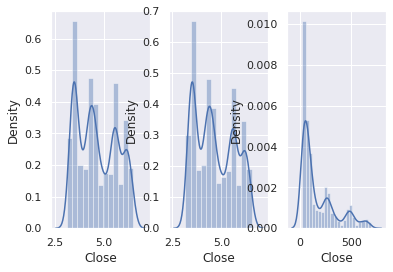

In [3]:
print(type(ts_log))
print(type(ts_log1p))
print(type(ts))

import seaborn as sns
fig = plt.figure()

sns.set(rc = {'figure.figsize':(15,5)})

area_1 = fig.add_subplot(1,3,1)
area_2 = fig.add_subplot(1,3,2)
area_3 = fig.add_subplot(1,3,3)

sns.distplot(ts_log, ax=area_1)
sns.distplot(ts_log1p, ax=area_2)
sns.distplot(ts, ax=area_3)

print("Skewness: {:.3f}".format(ts_log.skew()))
print("Kurtosis: {:.3f}".format(ts_log.kurt()))

seaborn 사용법은 아래 블로그를 참고하자

https://continuous-development.tistory.com/153

seaborn 피규어 사이즈 변경 방법

https://www.delftstack.com/ko/howto/seaborn/size-of-seaborn-plot/

<br/>
확인 결과 log1p()와 log()로 변환시켜준 값에 차이가 없다
<br/>아무거나 해도 될 거 같다

# STEP 3 : 시계열 안정성 분석

* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Times Series Decomposition
* Residual 안정성 확인

## 가설

일단 정성적 그래프 분석은 원리 이해를 위한 분석이고
<br/>정략적 그래프 분석은 양적 이해를 위한 분석이라는 것만 알겠다
<br/>뭐 어떻게 가설을 세워야 하지?

정량적은 특정 기준을 가지고 해야된다
<br/>근데 뭘 기준으로 해야되지?

<br/>정서적 그래프는 메커니즘을 이해하기 위한 거라 하면 특정 데이터의 일정 양을 넘으면 생기는 다른 현상을 말하는 건가??
<br/>그럼 정량적 그래프는 위에서 그린 그래프 그 자체를 말하는 건가?


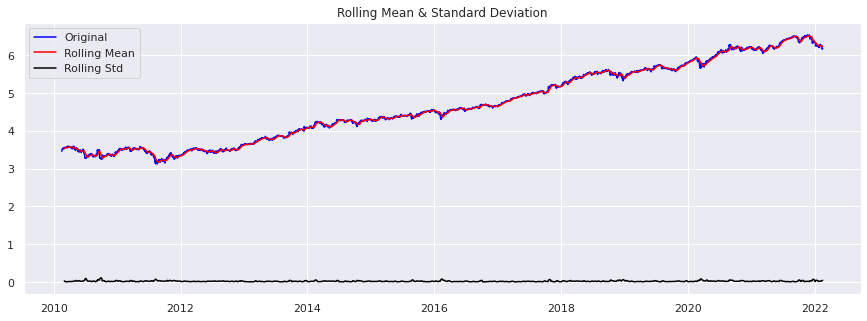

Results of Dickey-Fuller Test:
Test Statistic                    0.166776
p-value                           0.970335
#Lags Used                       16.000000
Number of Observations Used    3006.000000
Critical Value (1%)              -3.432527
Critical Value (5%)              -2.862502
Critical Value (10%)             -2.567282
dtype: float64


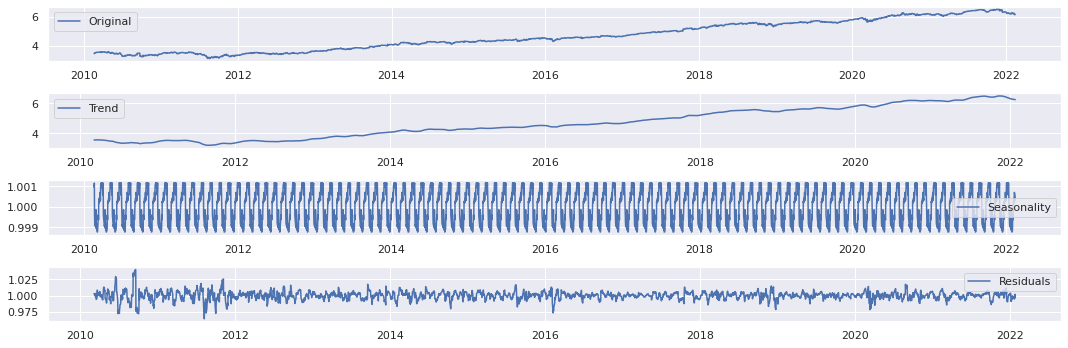

In [4]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

from statsmodels.tsa.stattools import adfuller


def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [21]:
print(trend)

Date
2010-02-16   NaN
2010-02-17   NaN
2010-02-18   NaN
2010-02-19   NaN
2010-02-22   NaN
              ..
2022-02-09   NaN
2022-02-10   NaN
2022-02-11   NaN
2022-02-14   NaN
2022-02-15   NaN
Name: trend, Length: 3023, dtype: float64


In [5]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.514433e+01
p-value                        6.939253e-28
#Lags Used                     2.800000e+01
Number of Observations Used    2.964000e+03
Critical Value (1%)           -3.432558e+00
Critical Value (5%)           -2.862516e+00
Critical Value (10%)          -2.567289e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성

* 학습, 테스트 데이터셋 분리

## 가설

train_test_split()으로 분리하고자 한다

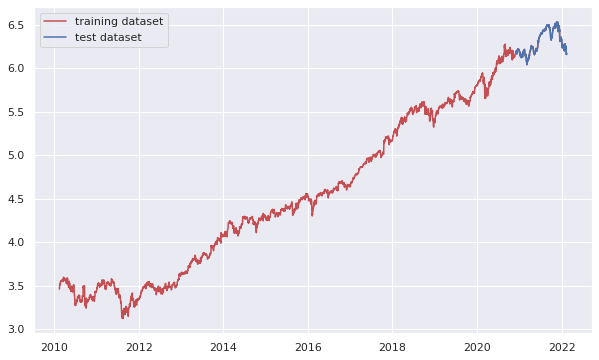

In [6]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

음 일단 맨 처음 코드는 train_test_split이랑 같다
두번째 부터는 그래프를 만드는 코드다


<br/>

[plt.grid 는 그래프에 그리드 무늬를 넣어줄 것인가를 정해주는 기능이다](https://wikidocs.net/92088)

[plt.legend 는 그래프 범례를 표시해주는 기능이다](https://codetorial.net/matplotlib/set_legend.html)

# STEP 5 : 적정 ARIMA 모수 찾기

* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

## 가설


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


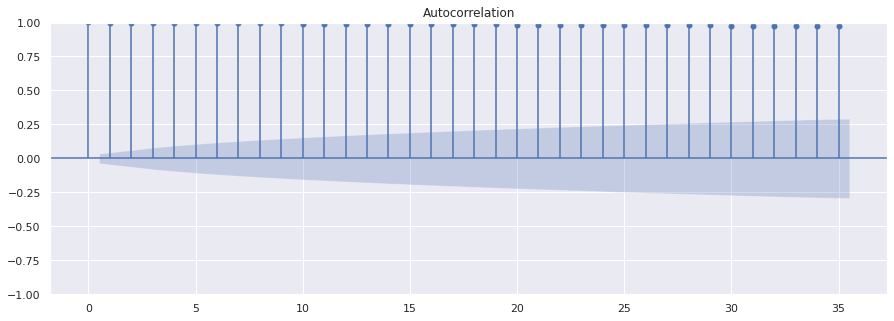

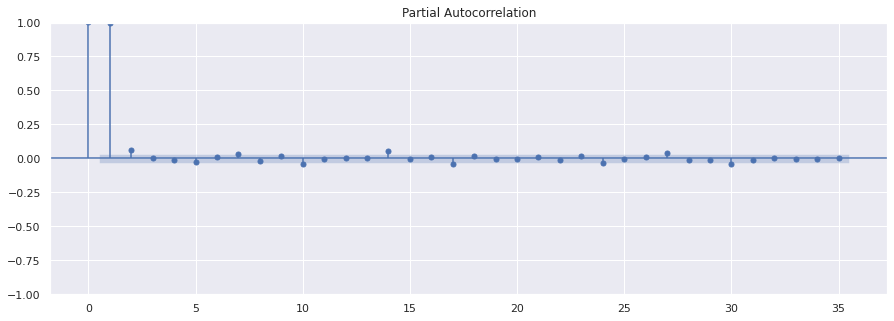

In [7]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.416936e+01
p-value                        2.015906e-26
#Lags Used                     1.500000e+01
Number of Observations Used    3.006000e+03
Critical Value (1%)           -3.432527e+00
Critical Value (5%)           -2.862502e+00
Critical Value (10%)          -2.567282e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.766215e+01
p-value                        3.677844e-30
#Lags Used                     2.800000e+01
Number of Observations Used    2.992000e+03
Critical Value (1%)           -3.432537e+00
Critical Value (5%)           -2.862506e+00
Critical Value (10%)          -2.567284e+00
dtype: float64


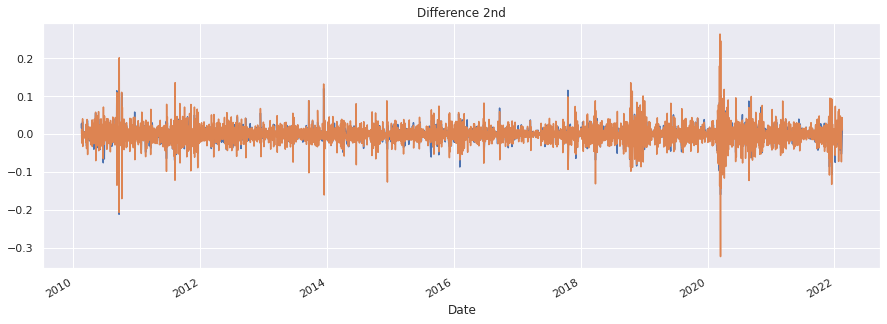

In [8]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트

* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

## 가설


In [9]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2720
Model:                 ARIMA(2, 0, 1)   Log Likelihood                6882.534
Date:                Thu, 17 Feb 2022   AIC                         -13755.068
Time:                        14:37:36   BIC                         -13725.526
Sample:                             0   HQIC                        -13744.389
                               - 2720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4937     14.410      0.312      0.755     -23.749      32.736
ar.L1          0.0070      0.005      1.451      0.147      -0.002       0.016
ar.L2          0.9929      0.005    205.132      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


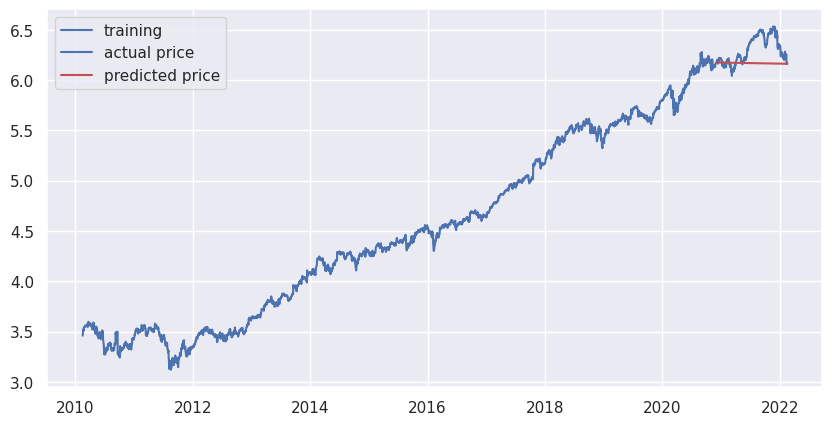

In [10]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  10832.022366133278
MAE:  79.65166806572283
RMSE:  104.07700210004744
MAPE: 13.18%


새로운 feature을 만들어주고 싶다

1. 뉴스를 보고 긍정적인지 부정적인지 판단하는 모델을 만든다
2. 부정적이라고 판단하면, 해당 주가가 떨어질 거라는 가중치를 준다
3. 실제 그래프를 보고 주가가 떨어졌는지 올랐는지 확인한다

<br/>

1. 재무제표와 주가 차트와의 상관성을 찾아서 예측을 하게 만든다
2. 이때 뉴스를 보고 긍정적인지 부정적인지를 판단하는 모델의 가중치도 감안하게 만든다

해외 기업 재무제표 다운 방법
<br/>
https://m.blog.naver.com/jaehoon-/220946013892
<br/>

재무제표 엑셀로 다운 방법
<br/>
https://medium.com/deepsearch/%EC%86%90%EC%89%BD%EA%B2%8C-%EC%9E%AC%EB%AC%B4%EC%A0%9C%ED%91%9C%EB%A5%BC-%EC%97%91%EC%85%80%EB%A1%9C-%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C-%EB%B0%9B%EC%9C%BC%EB%A0%A4%EB%A9%B4-b7b676eb2508

<br/>

1. 회사가 어느 나라에 있는지 데이터 추출
2. 회사가 전 세계에 얼마나 분포하고 있는지 데이터 추출
3. 추출한 정보와 주가 차트와의 상관성을 찾아서 예측에 도움 주기
4. 이때 회사가 속한 나라에 따라 가중치를 다르게 준다



해외 재무제표 다운 방법

https://rubber-tree.tistory.com/15

<br/>

Adobe 재무제표 다운 가능한 주소

https://stockrow.com/ADBE/financials/income/quarterly

<br/>

네이버 금융 재무제표 분석 코드

https://www.jaehongkoo.com/resume/8/

<br/>

In [12]:
dataset_inc_filepath = 'financials.csv'
df_inc = pd.read_csv(dataset_inc_filepath, parse_dates=True)
#df_inc = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

#ts_inc = df_inc['Revenue']
#ts_inc = df_inc['Close']

df_inc.head()

,Unnamed: 0,11/30/2021,8/31/2021,5/31/2021,2/28/2021,11/30/2020,8/31/2020,5/31/2020,2/29/2020,11/30/2019,...,5/31/2014,2/28/2014,11/30/2013,8/31/2013,5/31/2013,2/28/2013,11/30/2012,8/31/2012,5/31/2012,2/29/2012
0,Revenue,4.100000e+09,3.940000e+09,3.846000e+09,3.916000e+09,3.432000e+09,3.225000e+09,3.128000e+09,3.091000e+09,2.992000e+09,...,1.068208e+09,1.000120e+09,1.041699e+09,9.951190e+08,1.010549e+09,1.007873e+09,1.153428e+09,1.080580e+09,1.124449e+09,1.045220e+09
1,Revenue Growth,1.946000e-01,2.217000e-01,2.295000e-01,2.669000e-01,1.471000e-01,1.380000e-01,1.399000e-01,1.884000e-01,2.140000e-01,...,5.710000e-02,-7.700000e-03,-9.690000e-02,-7.910000e-02,-1.013000e-01,-3.570000e-02,1.100000e-03,6.650000e-02,9.900000e-02,1.700000e-02
2,Cost of Revenue,5.470000e+08,5.100000e+08,4.880000e+08,4.920000e+08,4.670000e+08,4.270000e+08,4.150000e+08,4.520000e+08,4.530000e+08,...,1.549040e+08,1.485090e+08,1.475160e+08,1.470760e+08,1.352810e+08,1.566840e+08,1.249780e+08,1.196210e+08,1.309180e+08,1.082650e+08
3,Gross Profit,3.553000e+09,3.430000e+09,3.358000e+09,3.424000e+09,2.965000e+09,2.798000e+09,2.713000e+09,2.639000e+09,2.539000e+09,...,9.133040e+08,8.516110e+08,8.941830e+08,8.480430e+08,8.752680e+08,8.511890e+08,1.028450e+09,9.609590e+08,9.935310e+08,9.369550e+08
4,R&D Expenses,6.570000e+08,6.510000e+08,6.120000e+08,6.200000e+08,5.580000e+08,5.660000e+08,5.320000e+08,5.320000e+08,4.990000e+08,...,2.090920e+08,2.095250e+08,2.051960e+08,2.087000e+08,2.030970e+08,2.096380e+08,1.950470e+08,1.891450e+08,1.809030e+08,1.777280e+08


In [13]:
df_inc = df_inc.transpose()
df_inc

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expenses,Operating Income,Interest Expense (Operating),Non-operating Interest Expenses,Non-operating Income/Expense,...,EBIT,Income from Continuous Operations,Consolidated Net Income/Loss,"EPS (Basic, from Continuous Ops)","EPS (Diluted, from Cont. Ops)","EPS (Basic, Consolidated)","EPS (Diluted, Consolidated)","Shares (Diluted, Average)",EBITDA Margin,Operating Cash Flow Margin
11/30/2021,4100000000.0,0.1946,547000000.0,3553000000.0,657000000.0,1405000000.0,1501000000.0,28000000.0,28000000.0,5000000.0,...,1501000000.0,1233000000.0,1233000000.0,2.6008,2.5743,2.6008,2.5743,480000000.0,0.4185,0.5039
8/31/2021,3940000000.0,0.2217,510000000.0,3430000000.0,651000000.0,1333000000.0,1441000000.0,27000000.0,27000000.0,-1000000.0,...,1441000000.0,1212000000.0,1212000000.0,2.5409,2.5198,2.5409,2.5198,481000000.0,0.416,0.3563
5/31/2021,3846000000.0,0.2295,488000000.0,3358000000.0,612000000.0,1329000000.0,1406000000.0,28000000.0,28000000.0,-3000000.0,...,1406000000.0,1116000000.0,1116000000.0,2.3347,2.3202,2.3347,2.3202,481000000.0,0.4189,0.5169
2/28/2021,3916000000.0,0.2669,492000000.0,3424000000.0,620000000.0,1339000000.0,1454000000.0,30000000.0,30000000.0,-2000000.0,...,1454000000.0,1261000000.0,1261000000.0,2.6326,2.6108,2.6326,2.6108,483000000.0,0.4242,0.4525
11/30/2020,3432000000.0,0.1471,467000000.0,2965000000.0,558000000.0,1184000000.0,1215000000.0,28000000.0,6000000.0,-11000000.0,...,1215000000.0,2250000000.0,2250000000.0,4.6777,4.6513,4.6777,4.6513,484000000.0,0.4117,0.5192
8/31/2020,3225000000.0,0.138,427000000.0,2798000000.0,566000000.0,1122000000.0,1069000000.0,27000000.0,28000000.0,-9000000.0,...,1069000000.0,955000000.0,955000000.0,1.9896,1.9691,1.9896,1.9691,485000000.0,0.3907,0.4453
5/31/2020,3128000000.0,0.1399,415000000.0,2713000000.0,532000000.0,1125000000.0,1016000000.0,27000000.0,28000000.0,-16000000.0,...,1016000000.0,1100000000.0,1100000000.0,2.2869,2.268,2.2869,2.268,485000000.0,0.3849,0.3785
2/29/2020,3091000000.0,0.1884,452000000.0,2639000000.0,532000000.0,1128000000.0,937000000.0,33000000.0,33000000.0,-18000000.0,...,937000000.0,955000000.0,955000000.0,1.9813,1.957,1.9813,1.957,488000000.0,0.364,0.4287
11/30/2019,2992000000.0,0.214,453000000.0,2539000000.0,499000000.0,1029000000.0,969000000.0,NaN,36000000.0,-12000000.0,...,969000000.0,851000000.0,851000000.0,1.7621,1.7319,1.7621,1.7319,488851000.0,0.3877,0.4602


데이터프레임 행과 열 반전 방법

https://mizykk.tistory.com/132

In [14]:
ts_inc = df_inc[0][1:]
ts_inc

11/30/2021    4100000000.0
8/31/2021     3940000000.0
5/31/2021     3846000000.0
2/28/2021     3916000000.0
11/30/2020    3432000000.0
8/31/2020     3225000000.0
5/31/2020     3128000000.0
2/29/2020     3091000000.0
11/30/2019    2992000000.0
8/31/2019     2834000000.0
5/31/2019     2744000000.0
2/28/2019     2601000000.0
11/30/2018    2464616000.0
8/31/2018     2291076000.0
5/31/2018     2195360000.0
2/28/2018     2078947000.0
11/30/2017    2006595000.0
8/31/2017     1841074000.0
5/31/2017     1772190000.0
2/28/2017     1681646000.0
11/30/2016    1608419000.0
8/31/2016     1463967000.0
5/31/2016     1398709000.0
2/29/2016     1383335000.0
11/30/2015    1306404000.0
8/31/2015     1217768000.0
5/31/2015     1162158000.0
2/28/2015     1109181000.0
11/30/2014    1073328000.0
8/31/2014     1005409000.0
5/31/2014     1068208000.0
2/28/2014     1000120000.0
11/30/2013    1041699000.0
8/31/2013      995119000.0
5/31/2013     1010549000.0
2/28/2013     1007873000.0
11/30/2012    1153428000.0
8

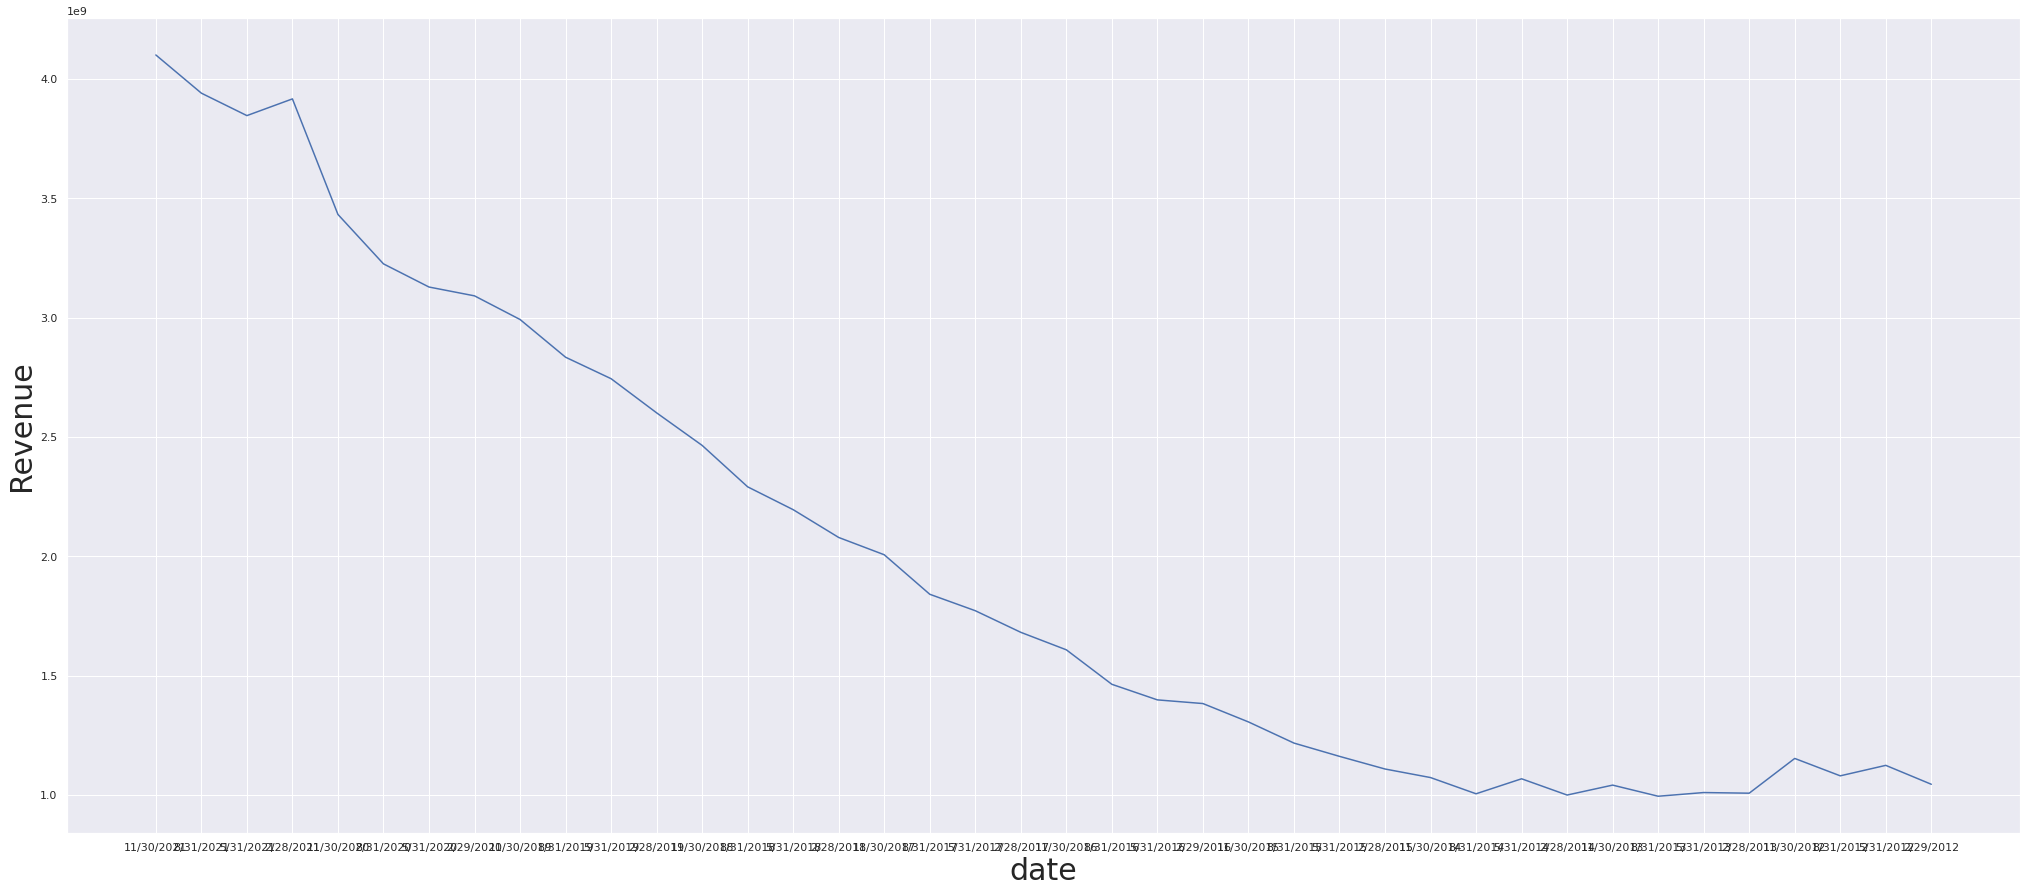

In [26]:
plt.subplots(figsize = (35, 15))
plt.ylabel('Revenue', fontsize=30)
plt.xlabel('date', fontsize=30)

plt.plot(ts_inc)

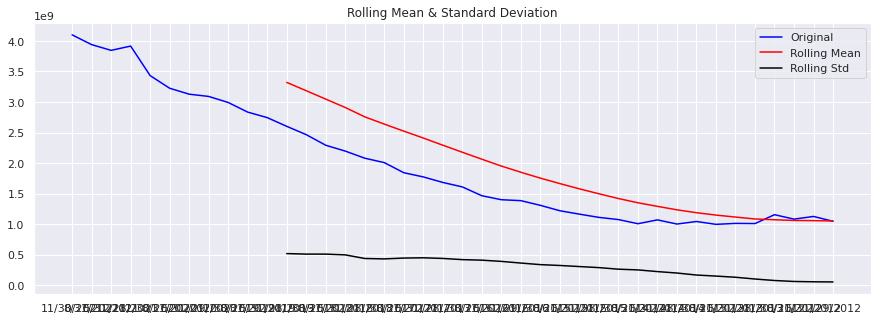

Results of Dickey-Fuller Test:
Test Statistic                 -1.967750
p-value                         0.300890
#Lags Used                      4.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


ValueError: x must have 2 complete cycles requires 60 observations. x only has 40 observation(s)

In [18]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_inc, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_inc)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_inc, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_inc, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

어머나 세상에...값이 60개가 안되기 때문에 decomposition을 실행할 수 없다는 에러 문구가 떴습니다...
이건 아무래도 포기해야 될 듯 합니다

애초에 제가 가져온 데이터가 분기별 데이터라 어느정도 일반화 되어있다고 생각합니다

In [22]:
print(trend)
print(residual)

Date
2010-02-16   NaN
2010-02-17   NaN
2010-02-18   NaN
2010-02-19   NaN
2010-02-22   NaN
              ..
2022-02-09   NaN
2022-02-10   NaN
2022-02-11   NaN
2022-02-14   NaN
2022-02-15   NaN
Name: trend, Length: 3023, dtype: float64
Date
2010-03-09    1.003161
2010-03-10    1.001542
2010-03-11    1.001422
2010-03-12    1.000090
2010-03-15    1.002326
                ...   
2022-01-19    0.998314
2022-01-20    0.997255
2022-01-21    0.994555
2022-01-24    1.001908
2022-01-25    0.996628
Name: resid, Length: 2993, dtype: float64


In [19]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.514433e+01
p-value                        6.939253e-28
#Lags Used                     2.800000e+01
Number of Observations Used    2.964000e+03
Critical Value (1%)           -3.432558e+00
Critical Value (5%)           -2.862516e+00
Critical Value (10%)          -2.567289e+00
dtype: float64


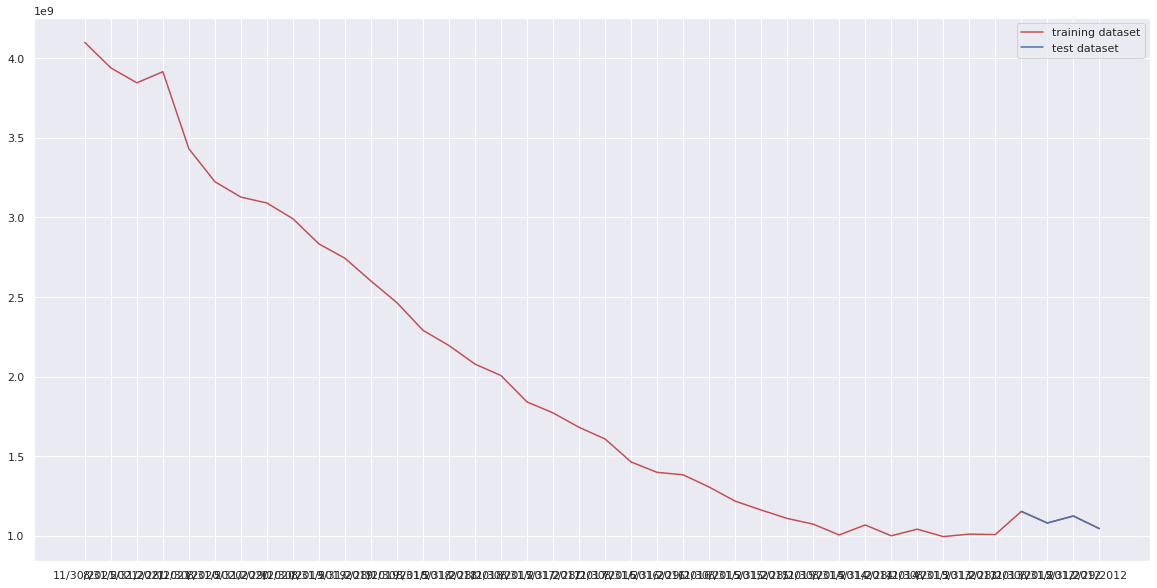

In [29]:
train_data, test_data = ts_inc[:int(len(ts_inc)*0.9)], ts_inc[int(len(ts_inc)*0.9):]
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(ts_inc, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


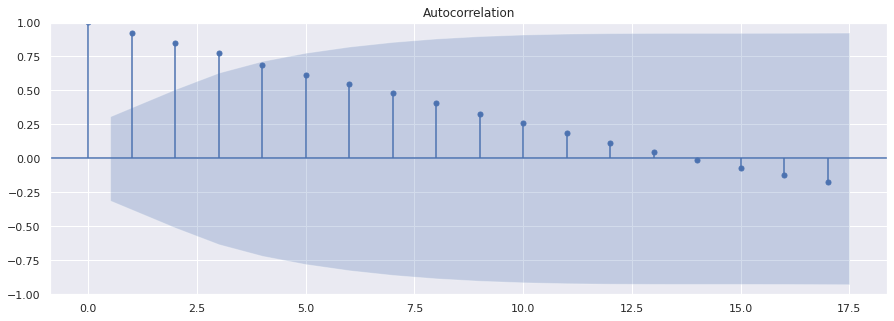

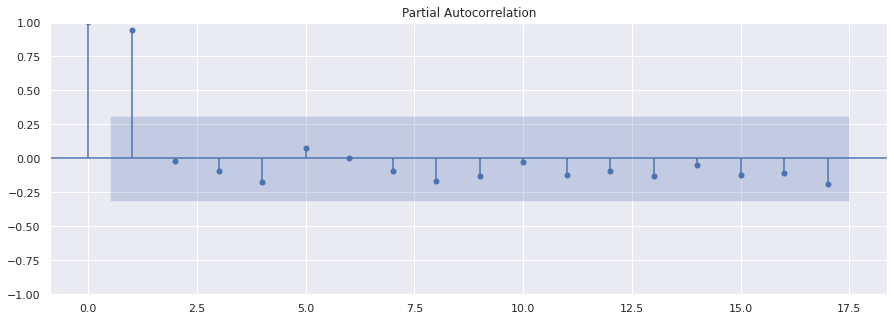

In [30]:
plot_acf(ts_inc)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_inc)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                 -1.822685
p-value                         0.369259
#Lags Used                      3.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.870978e+00
p-value                        3.995710e-17
#Lags Used                     2.000000e+00
Number of Observations Used    3.500000e+01
Critical Value (1%)           -3.632743e+00
Critical Value (5%)           -2.948510e+00
Critical Value (10%)          -2.613017e+00
dtype: float64


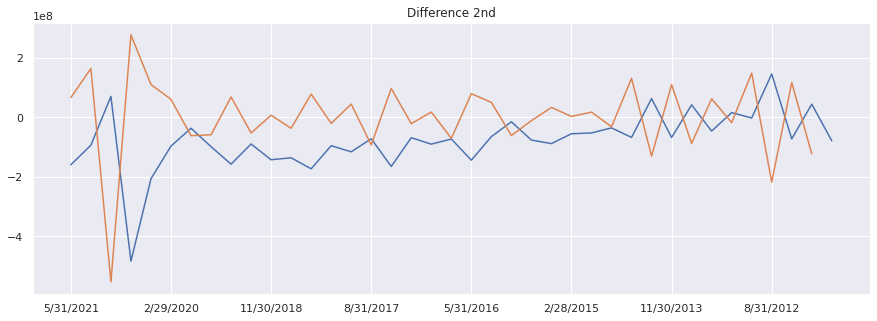

In [31]:
# 1차 차분 구하기
diff_1 = ts_inc.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [33]:
model = ARIMA(train_data, order=(2, 0, 1))
fitted_m = model.fit() 

print(fitted_m.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

# 갑작스러운 회고

시간이 없어서 더이상 진행을 할 수 없게 되었습니다
<br/>
이번 EX는 너무 성의없게 한 거 같아 많이 아쉽네요
<br/>

뭐 계획만 적어보고자 합니다
<br/>
일단 재무제표를 이용해서 모델을 만들 수 있는지 확인한 다음,
<br/>
데이터프레임을 새로 만들고자 했습니다
<br/>

### 어떤 식으로?

먼저 기존에 불러온 데이터에서 일부 행만을 가지고 주가를 예측하는 게 아니라,
<br/>
모든 데이터를 불러와서 주가 행을 제외하여 x로 정해주고,
<br/>
주가는 y로 정해줘서 다른 데이터와의 연관성을 찾아서 미래 주가 예측을 하고자 했습니다
